In [2]:
import folium
import pandas as pd
import numpy as np
import h3
from shapely.geometry import Polygon, Point
import shapely.wkt
from geojson import Point, Feature, FeatureCollection, dump
import seaborn as sns
from matplotlib import pyplot
from dateutil.parser import parse
from tqdm import tqdm

# Discriptive Analysis

# Prices

In [3]:
#Load price data
dfPrices = pd.read_csv("auction_spot_germany_luxembourg_2019.csv",skiprows=1,sep=';')
dfPrices

Delivery day   Hour1   Hour2  Hour3A Hour3B   Hour4   Hour5   Hour6  \
0     31.12.2019   24,14   22,12   13,01    NaN    4,97    9,81   18,37   
1     30.12.2019   11,07   11,84    6,16    NaN    1,40    4,81   16,43   
2     29.12.2019   30,60   28,10   26,92    NaN   22,85   20,97   21,31   
3     28.12.2019   30,17   29,50   29,43    NaN   28,20   28,53   27,40   
4     27.12.2019   31,17   30,02   28,67    NaN   28,70   29,19   31,03   
..           ...     ...     ...     ...    ...     ...     ...     ...   
360   05.01.2019   26,90   25,12   24,12    NaN   22,04   18,37   22,09   
361   04.01.2019   50,73   47,11   47,07    NaN   46,94   47,00   46,91   
362   03.01.2019   42,91   45,22   45,63    NaN   44,00   43,88   45,92   
363   02.01.2019  -33,57  -45,92  -48,29    NaN  -44,99  -48,93  -29,91   
364   01.01.2019   28,32   10,07   -4,08    NaN   -9,91   -7,41  -12,55   

      Hour7   Hour8  ... Peakload\r\n(09-20) Night\r\n(01-06)  \
0     23,50   27,17  ...               40,36            15,40   
1     26,90   30,38  ...               32,52             8,62   
2     22,72   25,10  ...               33,30            25,13   
3     29,20   31,63  ...               37,42            28,87   
4     33,10   38,89  ...               42,64            29,80   
..      ...     ...  ...                 ...              ...   
360   23,35   28,76  ...               51,30            23,11   
361   49,59   55,32  ...               53,32            47,63   
362   51,07   52,77  ...               65,00            44,59   
363   -0,01   37,43  ...               51,39           -41,94   
364  -17,25  -15,07  ...               -0,80             0,74   

    Off-Peak 1\r\n(01-08) Business\r\n(09-16) Off-Peak\r\n(01-08 & 21-24)  \
0                   17,89               37,78                       25,11   
1                   13,62               30,75                       18,61   
2                   24,82               30,67                       27,03   
3                   29,26               35,17                       31,17   
4                   31,35               40,86                       32,99   
..                    ...                 ...                         ...   
360                 23,84               47,62                       33,06   
361                 48,83               53,32                       46,50   
362                 46,43               63,16                       50,43   
363                -26,77               47,44                        0,44   
364                 -3,49               -1,96                       -7,80   

    Morning\r\n(07-10) High Noon\r\n(11-14) Afternoon\r\n(15-18)  \
0                31,92                36,93                41,48   
1                30,31                29,23                34,62   
2                26,35                31,04                34,29   
3                33,07                34,79                37,86   
4                37,64                40,26                45,81   
..                 ...                  ...                  ...   
360              32,30                49,69                54,67   
361              54,05                53,04                52,59   
362              56,69                62,34                67,74   
363              34,06                44,36                54,07   
364             -10,90                -1,10                 2,75   

    Evening\r\n(19-24) Sun Peak\r\n(11-16)  
0                41,99               37,55  
1                30,88               30,34  
2                34,42               31,31  
3                37,83               34,99  
4                39,00               41,39  
..                 ...                 ...  
360              54,51               50,65  
361              45,56               52,54  
362              61,76               63,73  
363              57,29               46,79  
364             -11,77               -0,74  

[365 rows x 46 columns]

In [4]:
dfOnlyPrices = pd.DataFrame()

#Only consider prices for single hours
for column in dfPrices.columns:
    if 'Hour' in column and 'Rush' not in column:
        dfOnlyPrices[column] = dfPrices[column].str.replace(",",".").astype(float)

#There are two 3 o'clock, one unused
dfOnlyPrices.drop('Hour3B',axis=1,inplace=True)
dfOnlyPrices.rename(columns={'Hour3A':'Hour3'},inplace=True)
dfOnlyPrices.head()

Hour1  Hour2  Hour3  Hour4  Hour5  Hour6  Hour7  Hour8  Hour9  Hour10  ...  \
0  24.14  22.12  13.01   4.97   9.81  18.37  23.50  27.17  36.56   40.43  ...   
1  11.07  11.84   6.16   1.40   4.81  16.43  26.90  30.38  32.04   31.90  ...   
2  30.60  28.10  26.92  22.85  20.97  21.31  22.72  25.10  27.52   30.04  ...   
3  30.17  29.50  29.43  28.20  28.53  27.40  29.20  31.63  34.61   36.82  ...   
4  31.17  30.02  28.67  28.70  29.19  31.03  33.10  38.89  38.55   40.00  ...   

   Hour15  Hour16  Hour17  Hour18  Hour19  Hour20  Hour21  Hour22  Hour23  \
0   38.00   39.58   42.28   46.06   47.73   46.00   42.20   39.74   38.88   
1   31.53   33.61   35.25   38.09   39.35   31.58   30.68   29.67   29.68   
2   30.80   32.86   33.97   39.53   41.16   39.60   38.14   32.00   30.11   
3   34.91   35.86   39.86   40.79   43.75   43.29   39.62   35.39   34.75   
4   42.20   45.13   46.53   49.38   44.88   43.99   39.52   36.67   35.38   

   Hour24  
0   37.39  
1   24.33  
2   25.52  
3   30.17  
4   33.57  

[5 rows x 24 columns]

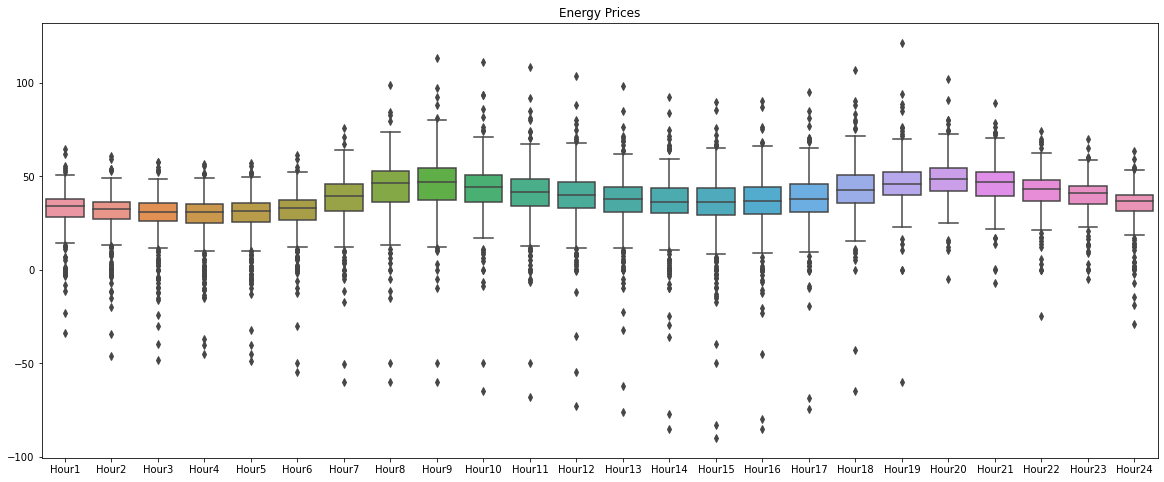

In [5]:
#Show prices for each hour of day
fig, ax = pyplot.subplots(figsize=(20, 8))
sns.boxplot(ax=ax, data=dfOnlyPrices).set_title('Energy Prices')
fig.savefig("energy_prices.png")

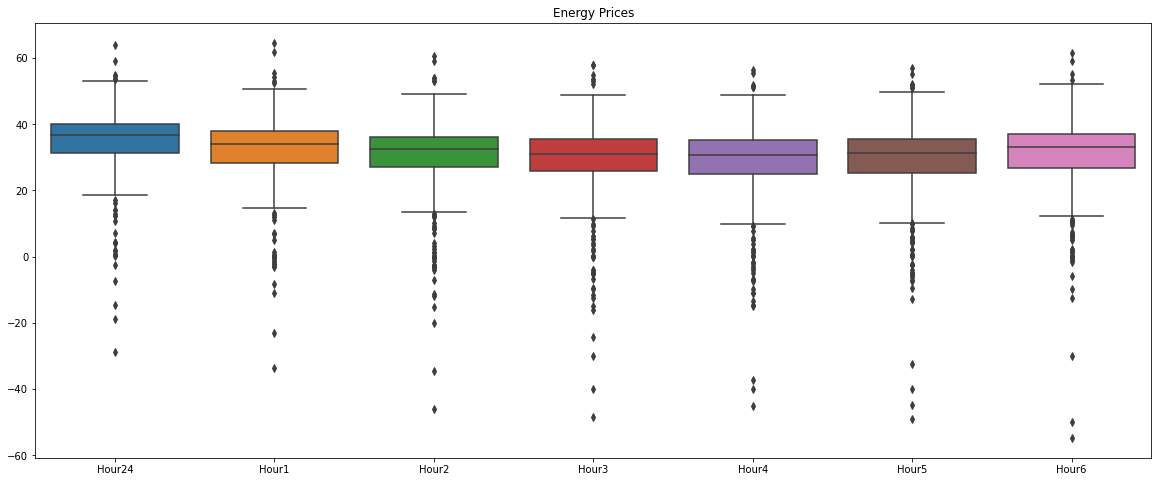

In [6]:
#Only show the timespan between 0 a.m. and 6 a.m.
dfSelection = dfOnlyPrices[['Hour24','Hour1','Hour2','Hour3','Hour4','Hour5','Hour6',]]
fig, ax = pyplot.subplots(figsize=(20, 8))
sns.boxplot(ax=ax, data=dfSelection).set_title('Energy Prices')
fig.savefig("energy_prices.png")

# Demand Data

## Map Visualizations

### Create a GeoJson

In [7]:
#Deliver boundaries of a hexagon
def output_h3_id_attributes(h3_id):
    return Polygon(h3.h3_to_geo_boundary(h3_id, geo_json=True))

#Read in Demand Data
dfDemand = pd.read_csv('sharenow_supply_data_6mo.csv')

#Filter for unique end hexagons
list_EndUnique = list(dfDemand['hex_end_7'].unique())

#Create features for the geojson
features = []
for hexID in list_EndUnique:
    features.append(Feature(geometry=output_h3_id_attributes(hexID), properties={"hexID": hexID}))

#Combine features to a collection
feature_collection = FeatureCollection(features)

#Write into geojson
with open('berlin_hexagons.geojson', 'w') as f:
   dump(feature_collection, f)

In [8]:
#Get start hour
hours = []
for value in tqdm(dfDemand['datetime_start'].values):
    dt = parse(value)
    hours.append(dt.time().hour)
dfDemand['hour_start'] = hours

#Get end hour
hours = []
for value in tqdm(dfDemand['datetime_end'].values):
    dt = parse(value)
    hours.append(dt.time().hour)
dfDemand['hour_end'] = hours

100%|██████████| 338359/338359 [00:27<00:00, 12321.79it/s]


# Visulise

## Map _ Average Trip ends

In [9]:
#Only consider trips with SOC lower then 50%
#Count number of cars per hexagon
dfLowSOC_IDCount = dfDemand[dfDemand['fuel_end']<50].groupby(['date_start','hex_end_7'])['id'].count()
dfLowSOC_IDCount = dfLowSOC_IDCount.reset_index()

In [10]:
#Aggregate to hexagons
dfLowSOC_IDCount = dfLowSOC_IDCount[['hex_end_7','id']]
dfLowSOC_IDCount = dfLowSOC_IDCount.groupby('hex_end_7').sum()
dfLowSOC_IDCount = dfLowSOC_IDCount.reset_index()
dfLowSOC_IDCount = dfLowSOC_IDCount.rename(columns={'hex_end_7':'hexID','id':'trips'})

In [11]:
#Get average trip ends per hexagon
dfLowSOC_IDCount['trips'] = dfLowSOC_IDCount['trips']/len(dfDemand.date_end.unique())

In [12]:
#Avoid black points 
#Get all hex ids, fill with 0
possibleIds = dfDemand.hex_end_7.unique()

for id in possibleIds:
    if id not in dfLowSOC_IDCount['hexID'].unique():
        dfLowSOC_IDCount = dfLowSOC_IDCount.append({'hexID':id,'trips':0},ignore_index=True)

f = folium.Figure(width=500, height=500)
map = folium.Map(location=[52.518839, 13.399304], default_zoom_start=30)
map.choropleth(geo_data="berlin_hexagons.geojson",
             data=dfLowSOC_IDCount, 
             columns=['hexID', 'trips'], 
             key_on='feature.properties.hexID', 
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Average Trip Ends with low SOC per Day')
f.add_child(map)

### Single hours
Repeat the same on a hourly basis (given hour)

In [13]:
hour = 23
dfLowSoCHour_IDCount = dfDemand[(dfDemand['hour_end']==hour) & (dfDemand['fuel_end'] < 50)]

dfLowSoCHour_IDCount = dfLowSoCHour_IDCount.groupby(['hour_end','hex_end_7'])['id'].count()
dfLowSoCHour_IDCount = dfLowSoCHour_IDCount.reset_index()
dfLowSoCHour_IDCount = dfLowSoCHour_IDCount.rename(columns={'hex_end_7':'hexID','id':'trips'})

dfLowSoCHour_IDCount['trips'] = dfLowSoCHour_IDCount['trips']/len(dfDemand['date_start'].unique())

#Avoid black points 
#Get all hex ids
possibleIds = dfDemand.hex_end_7.unique()

for id in possibleIds:
    if id not in dfLowSoCHour_IDCount['hexID'].unique():
        dfLowSoCHour_IDCount = dfLowSoCHour_IDCount.append({'hexID':id,'trips':0},ignore_index=True)

f = folium.Figure(width=500, height=500)
map = folium.Map(location=[52.518839, 13.399304], default_zoom_start=30)
map.choropleth(geo_data="berlin_hexagons.geojson",
             data=dfLowSoCHour_IDCount, 
             columns=['hexID', 'trips'], 
             key_on='feature.properties.hexID', 
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Average Trip Ends per Day at {} a.m., SoC < 50%'.format(str(hour)))
f.add_child(map)

## Map _ Scenarios

In [14]:
#Read created Scenarios
dfScenarios = pd.read_csv('scenarios_multinomial.csv')

In [15]:
df_S1 = dfScenarios.iloc[0]
df_S1 = df_S1.T
df_S1 = df_S1.reset_index()
df_S1 = df_S1.rename(columns={'index':'hexID',0:'low_soc_cars'})
df_S1 = df_S1[df_S1['hexID']!='probs']

f = folium.Figure(width=500, height=500)
map = folium.Map(location=[52.518839, 13.399304], default_zoom_start=30)
map.choropleth(geo_data="berlin_hexagons.geojson",
             data=df_S1, 
             columns=['hexID', 'low_soc_cars'], 
             key_on='feature.properties.hexID', 
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='#Cars with SoC < 50%')
f.add_child(map)

In [16]:
df_S2 = dfScenarios.iloc[1]
df_S2 = df_S2.T
df_S2 = df_S2.reset_index()
df_S2 = df_S2.rename(columns={'index':'hexID',1:'low_soc_cars'})
df_S2 = df_S2[df_S2['hexID']!='probs']

f = folium.Figure(width=500, height=500)
map = folium.Map(location=[52.518839, 13.399304], default_zoom_start=30)
map.choropleth(geo_data="berlin_hexagons.geojson",
             data=df_S2, 
             columns=['hexID', 'low_soc_cars'], 
             key_on='feature.properties.hexID', 
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='#Cars with SoC < 50%')
f.add_child(map)

In [17]:
df_S3 = dfScenarios.iloc[2]
df_S3 = df_S3.T
df_S3 = df_S3.reset_index()
df_S3 = df_S3.rename(columns={'index':'hexID',2:'low_soc_cars'})
df_S3 = df_S3[df_S3['hexID']!='probs']

f = folium.Figure(width=500, height=500)
map = folium.Map(location=[52.518839, 13.399304], default_zoom_start=30)
map.choropleth(geo_data="berlin_hexagons.geojson",
             data=df_S3, 
             columns=['hexID', 'low_soc_cars'], 
             key_on='feature.properties.hexID', 
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='#Cars with SoC < 50%')
f.add_child(map)

In [18]:
df_S4 = dfScenarios.iloc[3]
df_S4 = df_S4.T
df_S4 = df_S4.reset_index()
df_S4 = df_S4.rename(columns={'index':'hexID',3:'low_soc_cars'})
df_S4 = df_S4[df_S4['hexID']!='probs']

f = folium.Figure(width=500, height=500)
map = folium.Map(location=[52.518839, 13.399304], default_zoom_start=30)
map.choropleth(geo_data="berlin_hexagons.geojson",
             data=df_S4, 
             columns=['hexID', 'low_soc_cars'], 
             key_on='feature.properties.hexID', 
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='#Cars with SoC < 50%')
f.add_child(map)

# Further Visualization

### Percipitation

In [19]:
#Binary value rain/no rain
precipitation = []
for value in dfDemand['precipitation'].values:
    if value == False:
        precipitation.append(0)
    else:
        precipitation.append(1)

dfDemand['precipitation'] = precipitation

#Add feature month
dfDemand['month'] = pd.to_datetime(dfDemand['date_start'],format='%Y%m%d').dt.month

In [20]:
#Get proportion of rain days
precipitation = dfDemand.groupby(['month']).mean()['precipitation']
dfPrecipitation = pd.DataFrame(precipitation).reset_index()

Text(0.5, 1.0, 'Average Precipitation per Month')

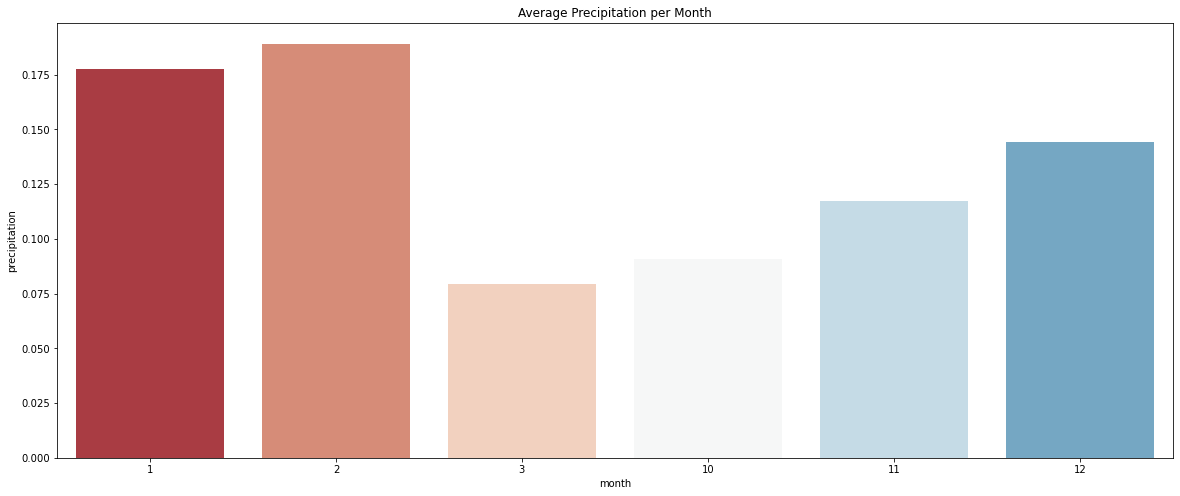

In [21]:
#Visualise
fig, ax = pyplot.subplots(figsize=(20, 8))
sns.barplot(ax=ax, data = dfPrecipitation, x='month', y='precipitation', palette=sns.color_palette("RdBu", 7)).set_title('Average Precipitation per Month')

## Temperature

In [22]:
#Get average temperature per month
temp = dfDemand.groupby(['month']).mean()['temp']
dfTemp = pd.DataFrame(temp).reset_index()

Text(0.5, 1.0, 'Average Temperature per Month')

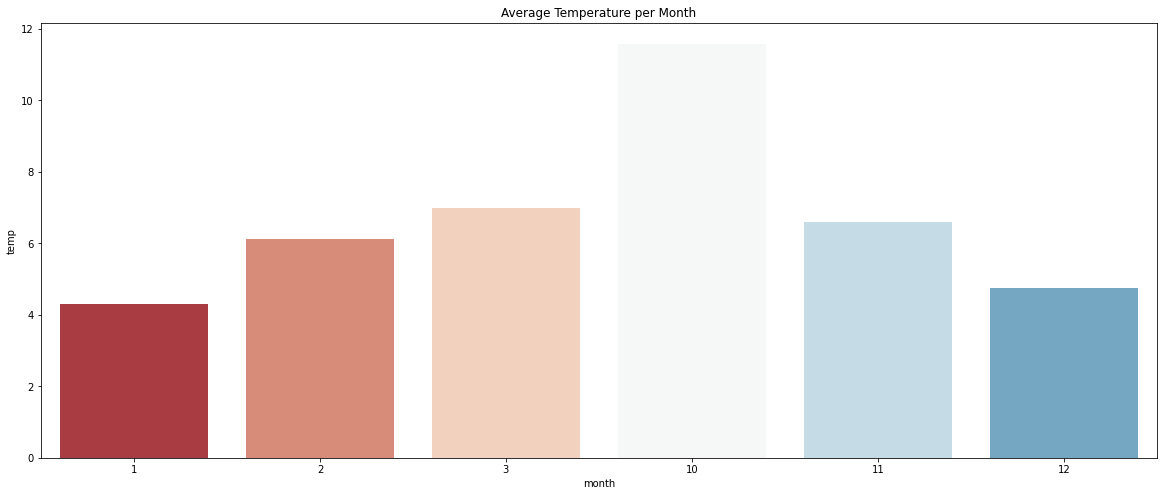

In [23]:
#Visualise temperature
fig, ax = pyplot.subplots(figsize=(20, 8))
sns.barplot(ax=ax, data = dfTemp, x='month', y='temp', palette=sns.color_palette("RdBu", 7)).set_title('Average Temperature per Month')

## Trip duration

In [24]:
#Add rounded duration
dfDemand['duration_mins_rounded'] = round(dfDemand['duration_mins'],0)

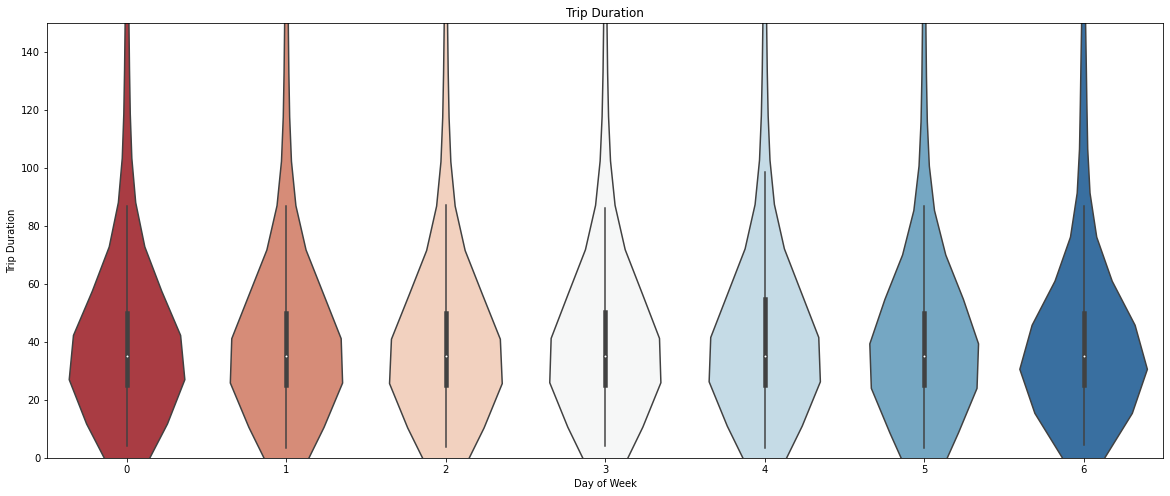

In [25]:
#Visualise trip duration for each month
fig, ax = pyplot.subplots(figsize=(20, 8))
ax.set(ylim=(0,150))
sns.violinplot(ax=ax, data=dfDemand, x='dayofweek',y='duration_mins',palette=sns.color_palette("RdBu", 7)).set_title('Trip Duration')
ax.set(xlabel='Day of Week', ylabel='Trip Duration')
fig.savefig("Trip_Duration.png")

## Number of trips

Text(0.5, 1.0, 'Duration')

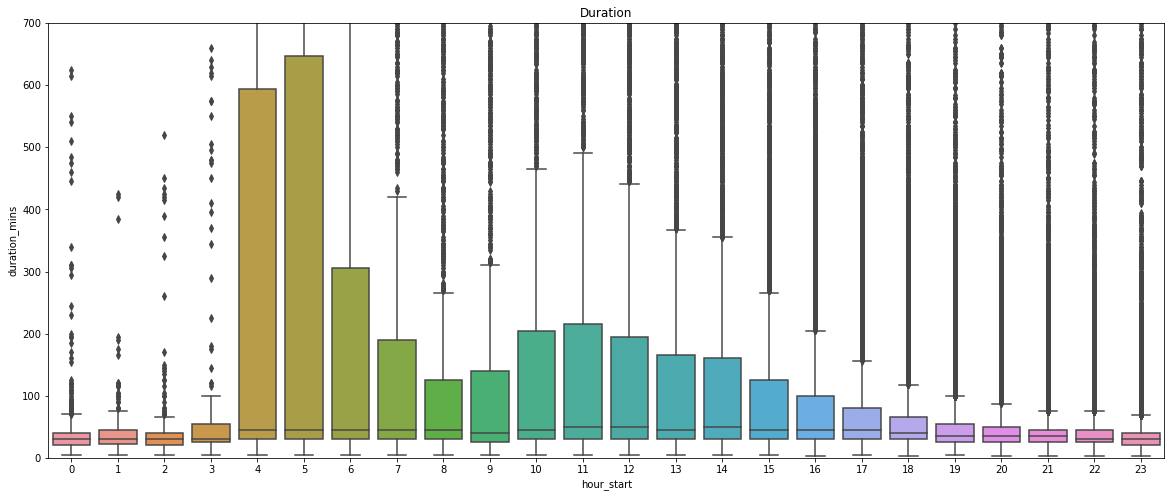

In [26]:
fig, ax = pyplot.subplots(figsize=(20, 8))
ax.set(ylim=(0,700))
sns.boxplot(ax=ax, data=dfDemand, x='hour_start',y='duration_mins').set_title('Duration')

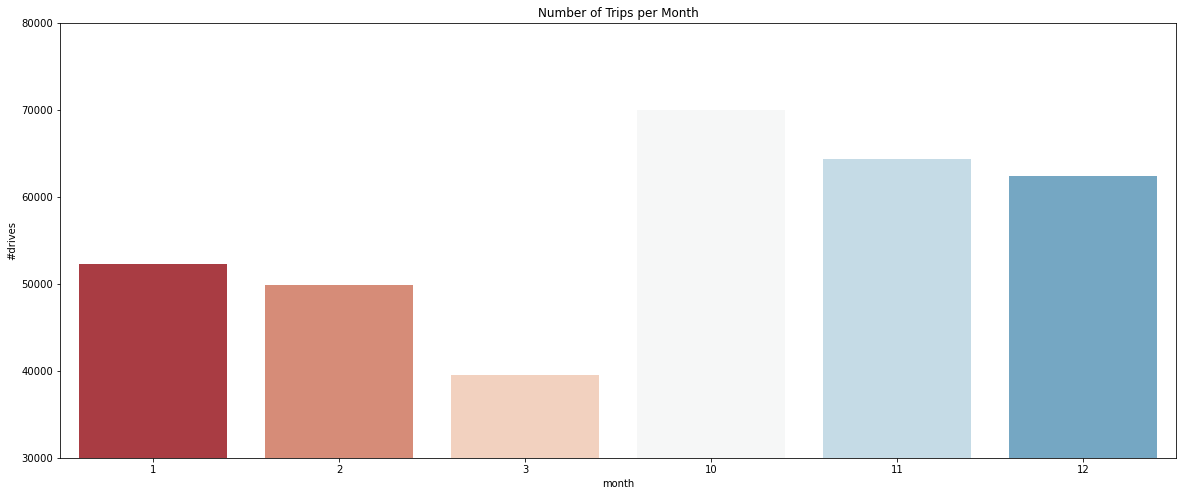

In [27]:
#Get number of trips per month
dfNumberTrips_Month = pd.DataFrame(dfDemand.value_counts('month')).reset_index()
dfNumberTrips_Month = dfNumberTrips_Month.rename(columns={0:'#drives'})

#Visualise
fig, ax = pyplot.subplots(figsize=(20, 8))
ax.set(ylim=(30000,80000))
sns.barplot(ax=ax, data = dfNumberTrips_Month, x= 'month', y='#drives', palette=sns.color_palette("RdBu", 7)).set_title('Number of Trips per Month')
fig.savefig("number_trips_per_month.png")

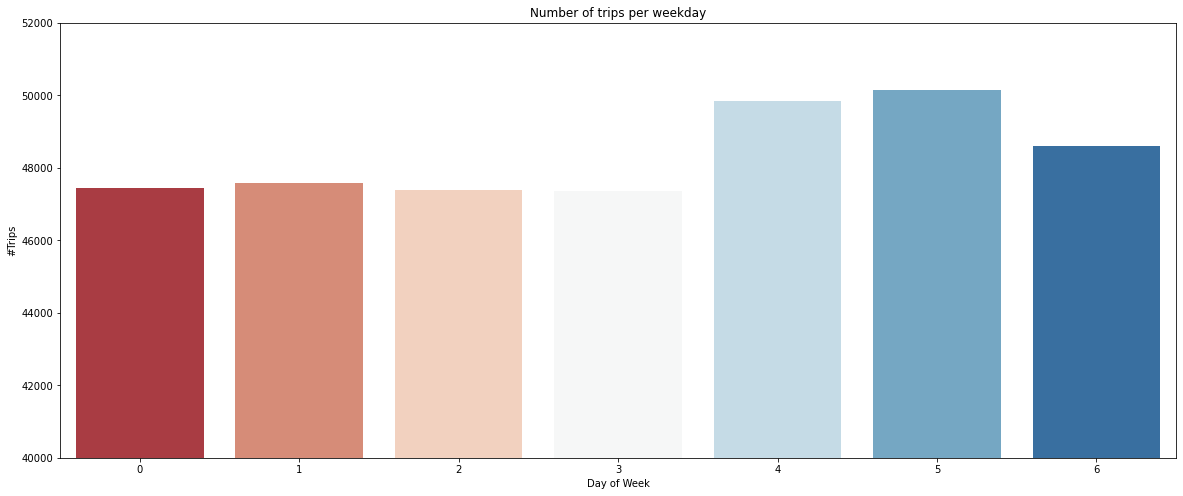

In [28]:
#Get Number of trips per weekday
dfNumberTrips_Weekday = pd.DataFrame(dfDemand.value_counts('dayofweek')).reset_index()
dfNumberTrips_Weekday = dfNumberTrips_Weekday.rename(columns={0:'#Trips'})

#Visualise
fig, ax = pyplot.subplots(figsize=(20, 8))
ax.set(ylim=(40000,52000))
sns.barplot(ax=ax, data = dfNumberTrips_Weekday, x= 'dayofweek', y='#Trips', palette=sns.color_palette("RdBu", 7)).set_title('Number of trips per weekday')
ax.set(xlabel='Day of Week', ylabel='#Trips')
fig.savefig("number_trips_per_weekday.png")

In [29]:
#Number of trips per month
dfNumberTrips_Month = pd.DataFrame(dfNumberTrips_Month.value_counts('month')).reset_index()
dfNumberTrips_Month = dfNumberTrips_Month.rename(columns={0:'#TripsMonthly'})

#Number of trips per month and weekday
dfNumberTrips_Weekday = pd.DataFrame(dfDemand.value_counts(['month','dayofweek'])).reset_index()
dfNumberTrips_Weekday = dfNumberTrips_Weekday.rename(columns={0:'#Trips'})

#Get percentual value
dfMerge = dfNumberTrips_Weekday.merge(dfNumberTrips_Month, on='month')
dfMerge['percentage_trips_weekday_monthly'] = dfMerge['#Trips']/dfMerge['#TripsMonthly']

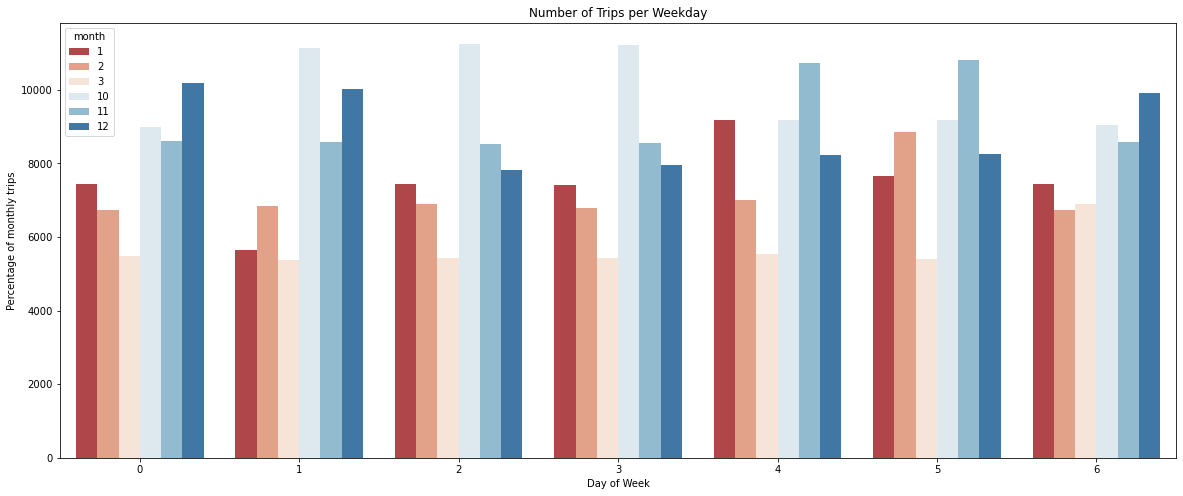

In [30]:
#Visualise
fig, ax = pyplot.subplots(figsize=(20, 8))
sns.barplot(ax=ax, data = dfMerge, x= 'dayofweek', y='percentage_trips_weekday_monthly',  hue='month', palette=sns.color_palette("RdBu", 6)).set_title('Number of Trips per Weekday')
ax.set(xlabel='Day of Week', ylabel='Percentage of monthly trips')
fig.savefig("percentual_trips_per_weekday_monthly.png")

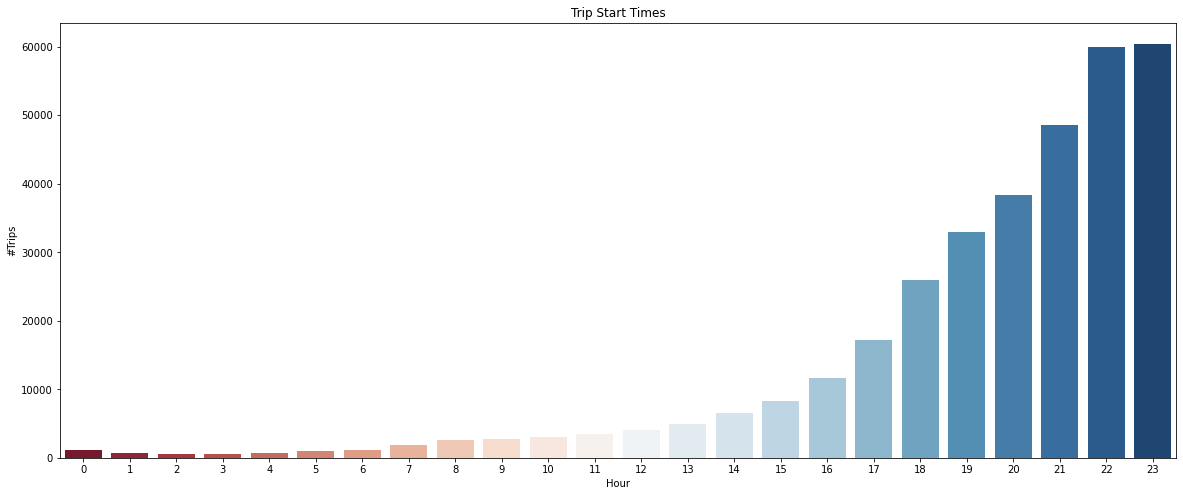

In [31]:
#Trips per start hour
fig, ax = pyplot.subplots(figsize=(20, 8))
sns.countplot(data=dfDemand, x='hour_start',palette=sns.color_palette("RdBu", 24)).set_title('Trip Start Times')
ax.set(xlabel='Hour', ylabel='#Trips')
fig.savefig("trip_starts_hourly.png")

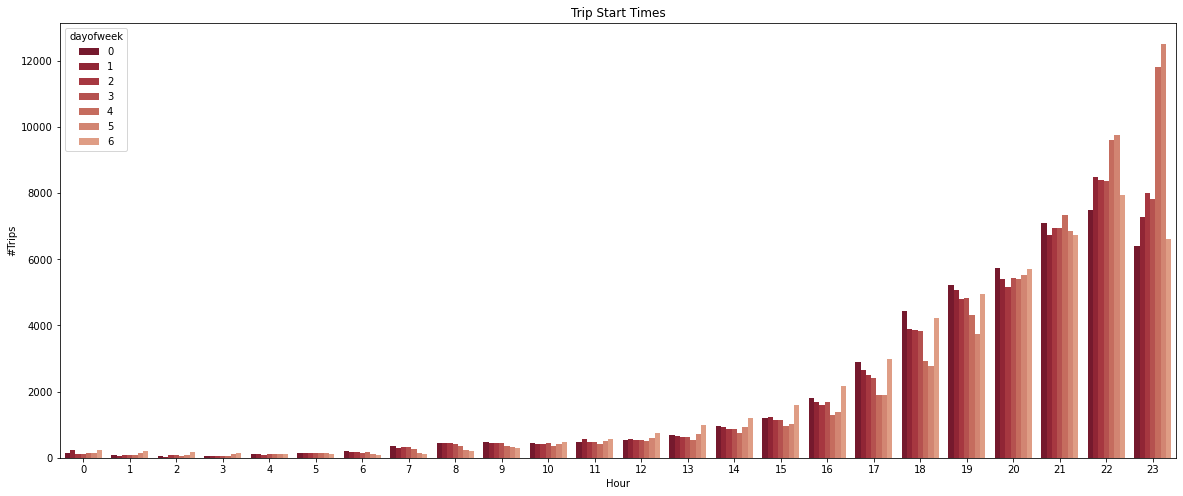

In [32]:
#Trips per month and start hour
fig, ax = pyplot.subplots(figsize=(20, 8))
sns.countplot(data=dfDemand, x='hour_start',hue='dayofweek',palette=sns.color_palette("RdBu", 24)).set_title('Trip Start Times')
ax.set(xlabel='Hour', ylabel='#Trips')
fig.savefig("trip_starts_hourly.png")

Text(0.5, 1.0, 'Trip Start Times')

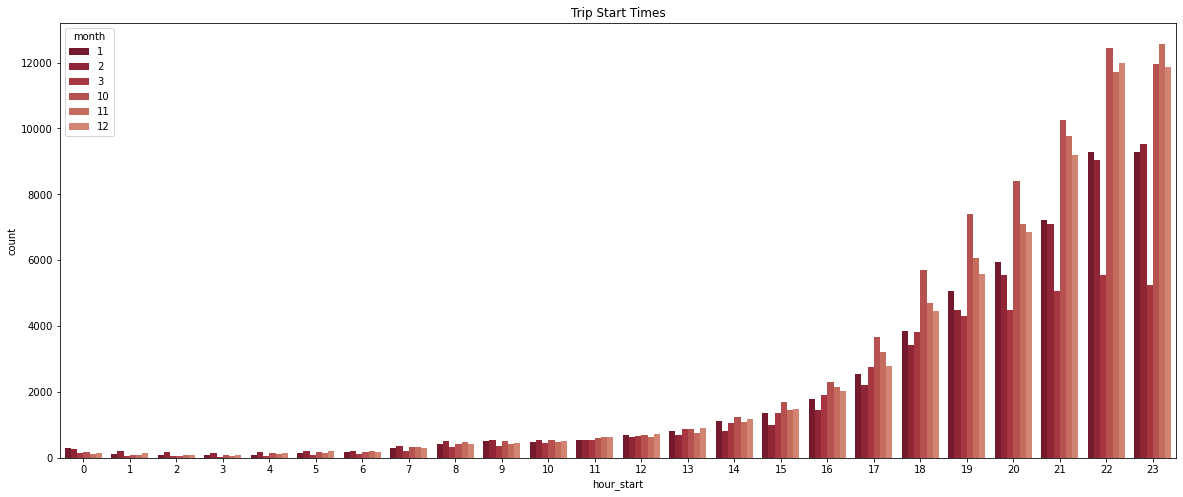

In [33]:
#Alternative version
fig, ax = pyplot.subplots(figsize=(20, 8))
sns.countplot(data=dfDemand, x='hour_start',hue='month',palette=sns.color_palette("RdBu", 24)).set_title('Trip Start Times')

In [35]:
#Get number of trips per hour
dfNumberTrips = pd.DataFrame(dfDemand.value_counts('hour_start'),columns=['#drives'])
dfNumberTrips = dfNumberTrips.reset_index()
dfNumberTrips = dfNumberTrips.sort_values('hour_start')

Text(0.5, 1.0, 'Number of Trips per Hour')

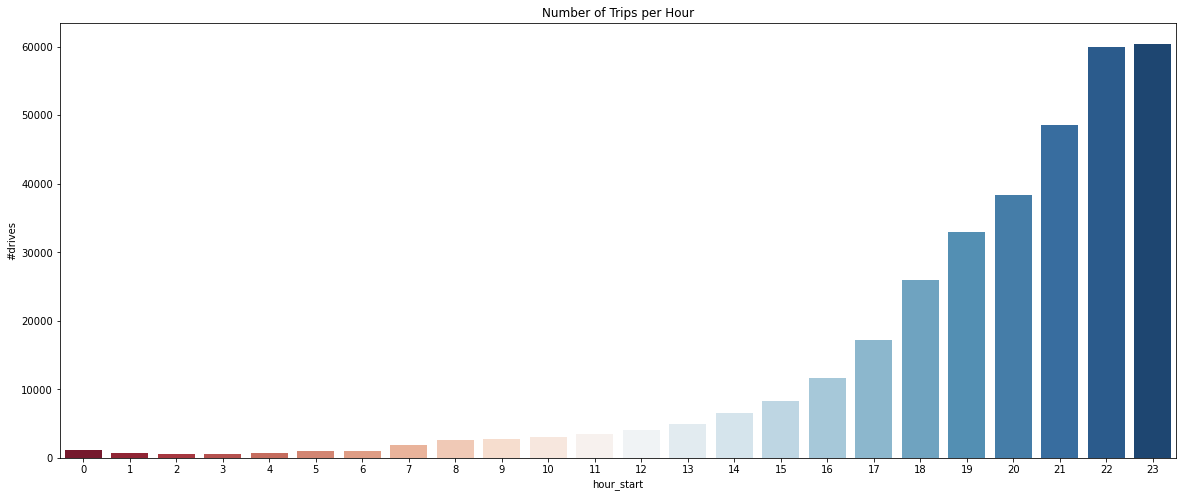

In [36]:
fig, ax = pyplot.subplots(figsize=(20, 8))
sns.barplot(ax=ax, data = dfNumberTrips, x= 'hour_start', y='#drives', palette=sns.color_palette("RdBu", 24)).set_title('Number of Trips per Hour')

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

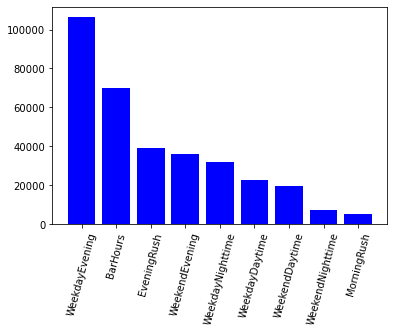

In [37]:
#Number of drives per timebucket
dfNumberTrips_TB = pd.DataFrame(dfDemand.value_counts('time_basket'),columns=['#drives'])
dfNumberTrips_TB = dfNumberTrips_TB.reset_index()

pyplot.bar(dfNumberTrips_TB['time_basket'],dfNumberTrips_TB['#drives'],color='blue')
pyplot.xticks(rotation=75)

### Other visualisations

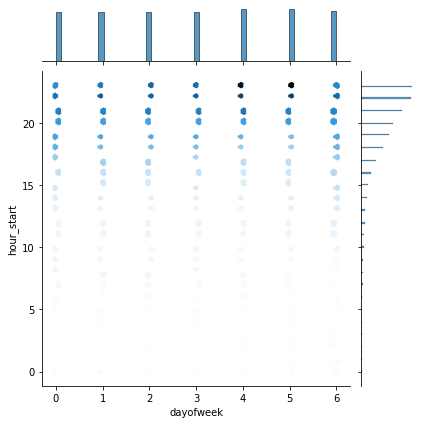

In [38]:
sns.jointplot(data=dfDemand, x="dayofweek", y="hour_start",kind='hex')

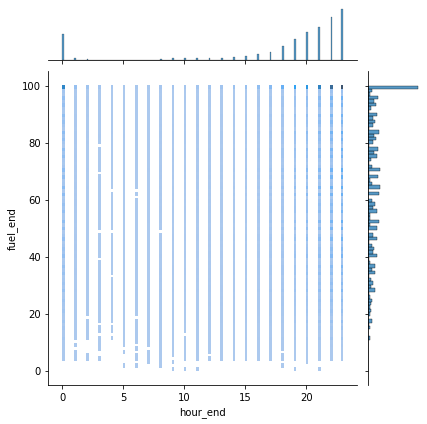

In [43]:
sns.jointplot(data=dfDemand, x="hour_end", y="fuel_end",kind='hist')

In [44]:
lowFuel = dfDemand[dfDemand['fuel_end'] < 50]
sns.jointplot(data=lowFuel, x="time_end", y="fuel_end", palette=sns.color_palette("RdBu"))